In [1]:
# store the module versions
#!pip freeze > ../requirements.txt

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_profiling as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import eli5
from eli5.sklearn import PermutationImportance
import scikitplot as skplt
from sklearn.decomposition import PCA

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) # display all columns

import warnings
warnings.filterwarnings('ignore')

## Loading the dataset  
read dataset, define delimiter, dtypes and encoding  

https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009#winequality-red.csv  
This datasets is related to red variants of the Portuguese "Vinho Verde" wine.  
**Determine which physiochemical properties make a wine 'good'!**  

the dependent variable is wine **quality**

In [5]:
# view top 5 lines from raw file
!head -n 5 ../data/dataset/winequality-red.csv

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6


In [6]:
df = pd.read_csv("../data/dataset/winequality-red.csv", sep=",")

In [7]:
df.shape

(1599, 12)

In [8]:
df.sample(5)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
1420            7.8              0.53         0.01             1.6      0.077   
192             6.8              0.63         0.12             3.8      0.099   
869             7.6              0.63         0.03             2.0      0.080   
669            11.3              0.34         0.45             2.0      0.082   
854             9.3              0.36         0.39             1.5      0.080   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
1420                  3.0                  19.0  0.99500  3.16       0.46   
192                  16.0                 126.0  0.99690  3.28       0.61   
869                  27.0                  43.0  0.99578  3.44       0.64   
669                   6.0                  15.0  0.99880  2.94       0.66   
854                  41.0                  55.0  0.99652  3.47       0.73   

      alcohol  quality  
1420      9.8        5  
192       9.5        5  
869      10.9        6  
669       9.2        6  
854      10.9        6

## rename columns

In [9]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [10]:
df.columns = ['fixedAcidity', 'volatileAcidity', 'citricAcid', 'residualSugar',
       'chlorideSalt', 'freeSulfurDioxide', 'totalSulfurDioxide', 'density',
       'pH', 'sulphatesAntiox', 'alcoholPct', 'qualityScore']

## Summarize data  
make a report.html

In [7]:
pp.ProfileReport(df).to_file("../data/report/index.html")

In [8]:
#There are 2 warnings
# citricAcid has 132 / 8.3% zeros
# Dataset has 240 duplicate rows

## Target incidence

In [9]:
# the target variable "quality" is continuous.
# aside from using regression modelling,
# is to set an arbitrary cutoff for the dependent variable at 7 or higher getting classified as 'good/1'
# and the remainder as 'not good/0'.

In [11]:
df["qualityDiscrete"] = pd.Series(df.apply(lambda x: 1 if x["qualityScore"] >= 7 else 0, axis=1))

In [12]:
df[["qualityScore","qualityDiscrete"]].sample(5)

qualityScore  qualityDiscrete
1470             5                0
153              5                0
1126             6                0
1484             4                0
985              6                0

In [13]:
# calculate the target incidence (preferred > 5%)
np.sum(df["qualityDiscrete"])/len(df)

0.1357098186366479

## create a PIG table

In [14]:
# Function that creates predictor insight graph table
def create_pig_table(df, variable, target):
  
    # Create groups for each variable
    groups = df[[target,variable]].groupby(variable)
    
    # Calculate size and target incidence for each group
    pig_table = groups[target].agg({'Size':np.size, 'Incidence':np.mean}).reset_index()
    
    # Return the predictor insight graph table
    return pig_table

In [15]:
# example for one random variable:
pig_table = create_pig_table(df, "volatileAcidity", "qualityDiscrete").sort_values(["Incidence"]).reset_index(drop=True)
pig_table

volatileAcidity  Size  Incidence
0              0.675     3   0.000000
1              0.830     4   0.000000
2              0.825     1   0.000000
3              0.820     5   0.000000
4              0.810     2   0.000000
5              0.805     1   0.000000
6              0.800     3   0.000000
7              0.795     2   0.000000
8              0.790     2   0.000000
9              0.785     8   0.000000
10             0.780    10   0.000000
11             0.775     4   0.000000
12             0.770     6   0.000000
13             0.765     5   0.000000
14             0.760     5   0.000000
15             0.755     3   0.000000
16             0.750     6   0.000000
17             0.745     5   0.000000
18             0.740    11   0.000000
19             0.730     6   0.000000
20             0.725     9   0.000000
21             0.720     5   0.000000
22             0.715    12   0.000000
23             0.710     3   0.000000
24             0.705     6   0.000000
25             0.700    10   0.000000
26             0.690    23   0.000000
27             0.680    12   0.000000
28             1.330     2   0.000000
29             0.670    23   0.000000
..               ...   ...        ...
113            0.660    26   0.192308
114            0.440    23   0.217391
115            0.635     9   0.222222
116            0.420    31   0.225806
117            0.380    35   0.228571
118            0.260    16   0.250000
119            0.840     8   0.250000
120            0.915     4   0.250000
121            0.370    24   0.250000
122            0.835     4   0.250000
123            0.320    23   0.260870
124            0.360    38   0.263158
125            0.350    22   0.272727
126            0.480    24   0.291667
127            0.290    16   0.312500
128            0.615     6   0.333333
129            0.585     3   0.333333
130            0.200     3   0.333333
131            0.815     3   0.333333
132            0.270    14   0.357143
133            0.240    13   0.384615
134            0.310    30   0.466667
135            0.210     6   0.500000
136            0.850     2   0.500000
137            0.395     2   0.500000
138            0.330    20   0.550000
139            0.280    23   0.565217
140            0.250     7   0.571429
141            0.300    16   0.625000
142            0.120     3   1.000000

[143 rows x 3 columns]

## create a PIG plot

In [16]:
def plot_pig(pig_table, variable):
    
    # Plot formatting
    plt.ylabel("Size", rotation=0, rotation_mode="anchor", ha="right" )
    
    # Plot the bars with sizes 
    pig_table["Size"].plot(kind="bar", width=0.5, color="lightgray", edgecolor="none") 
    
    # Plot the incidence line on secondary axis
    pig_table["Incidence"].plot(secondary_y=True)
    plt.ylim([0, 1])
    
    # Plot formatting
    plt.xticks(np.arange(len(pig_table)), pig_table[variable])
    plt.xlim([-0.5, len(pig_table) - 0.5])
    plt.ylabel("Incidence", rotation=0, rotation_mode="anchor", ha="left")
    plt.title(variable)
    
    plt.show()

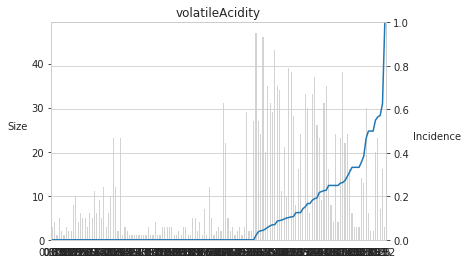

In [17]:
pig_table = create_pig_table(df, "volatileAcidity", "qualityDiscrete").sort_values(["Incidence"]).reset_index(drop=True)
plot_pig(pig_table, "volatileAcidity")

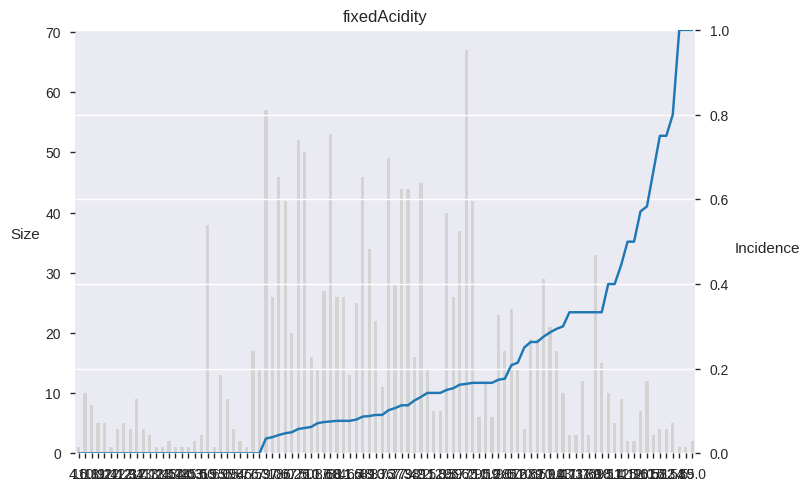

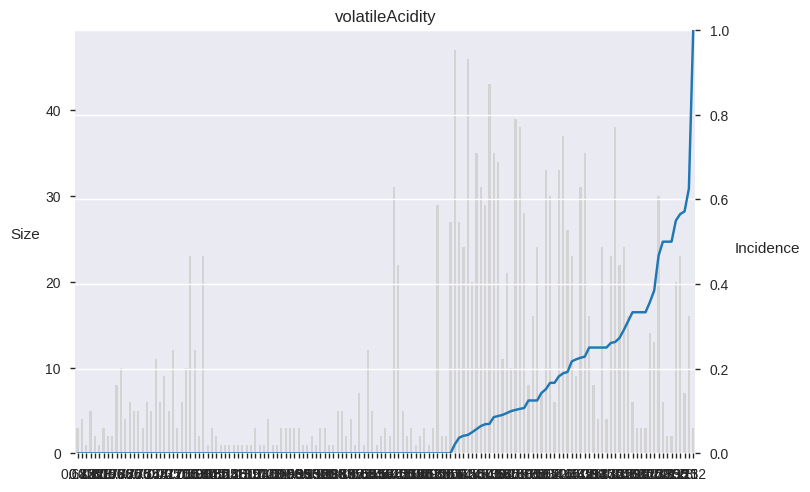

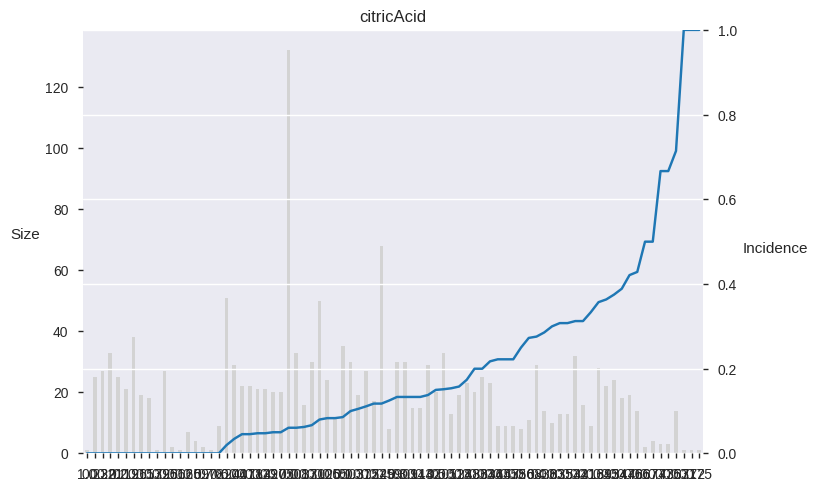

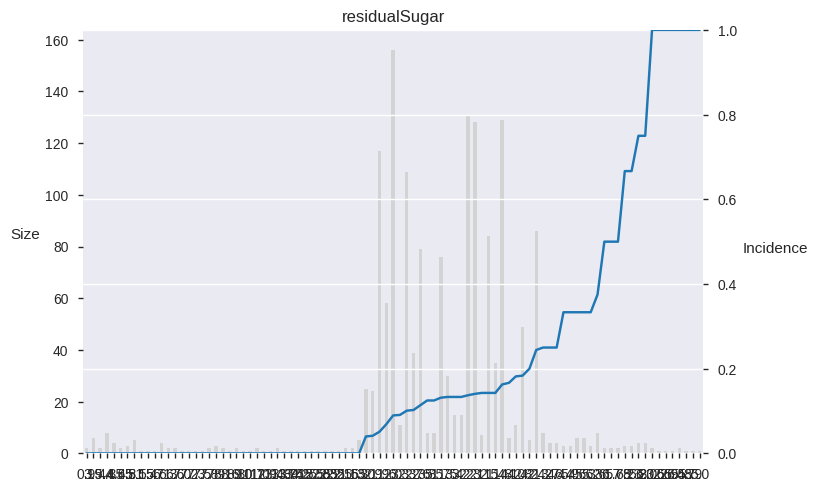

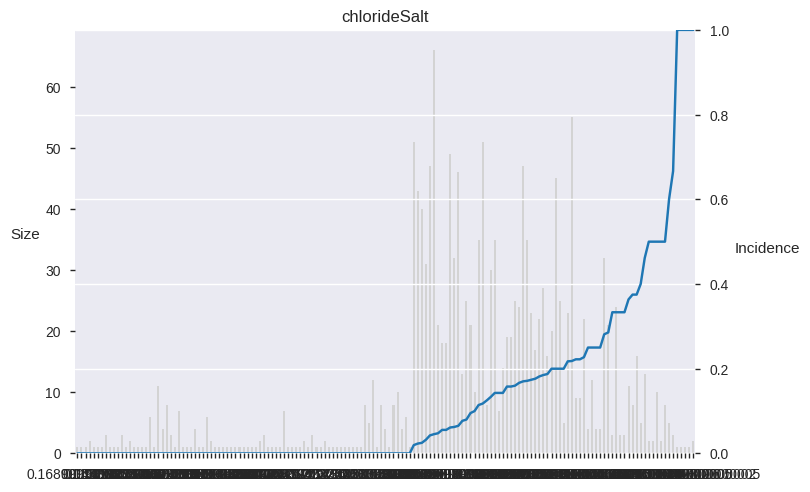

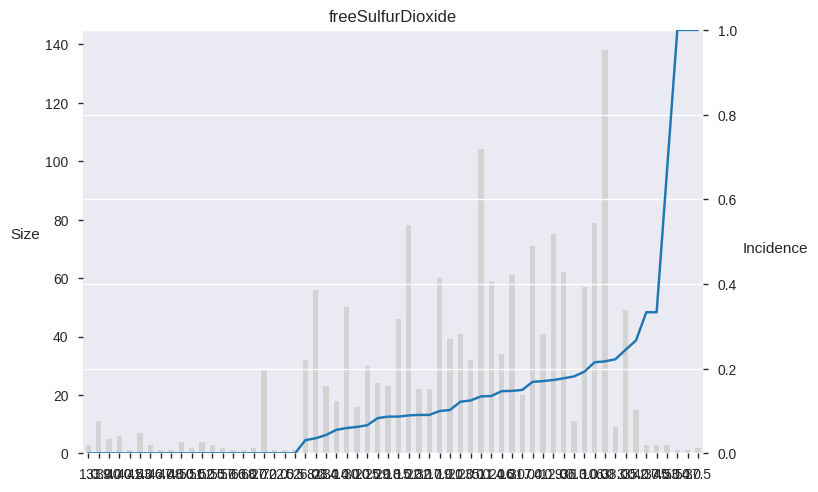

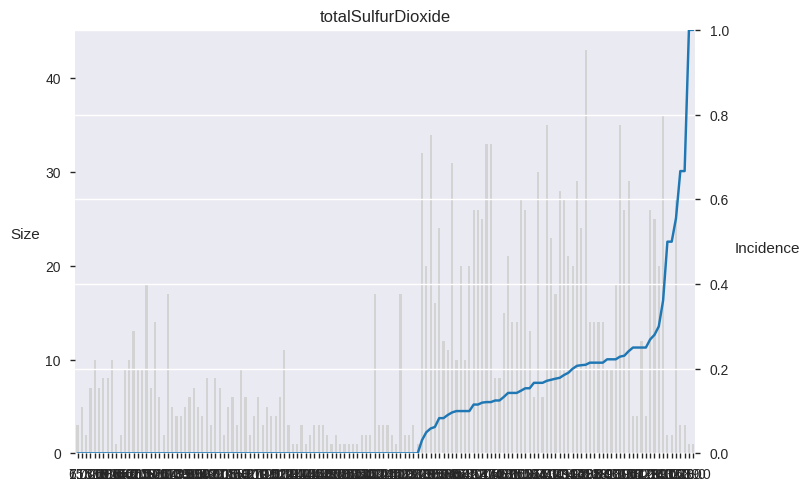

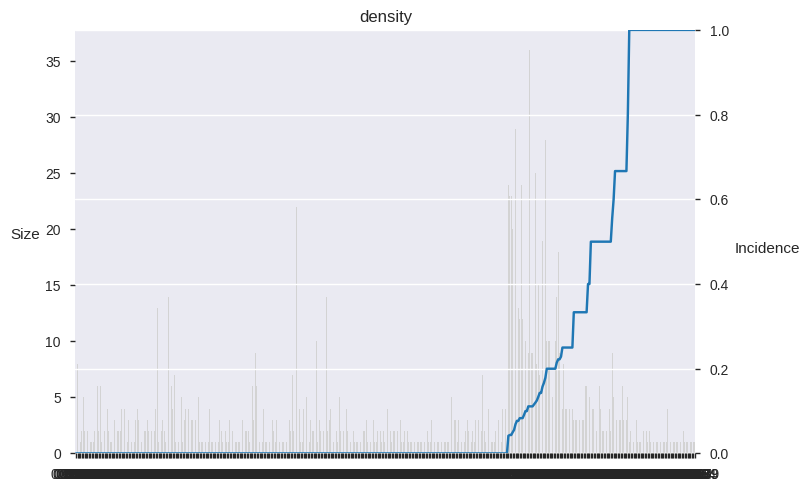

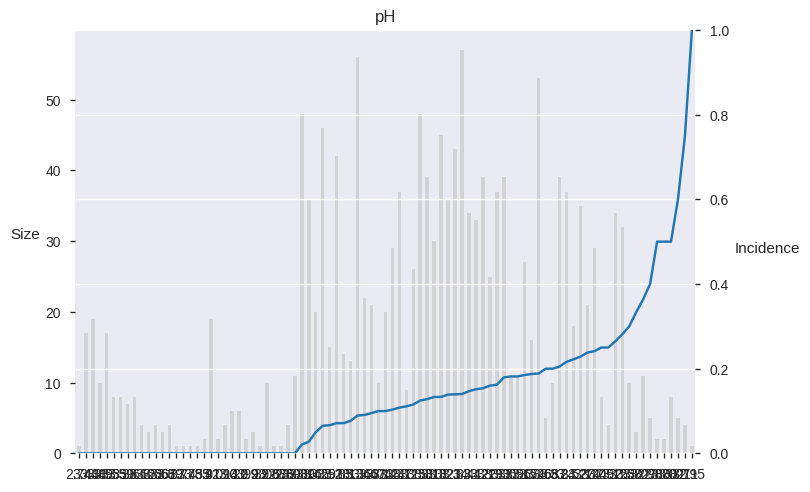

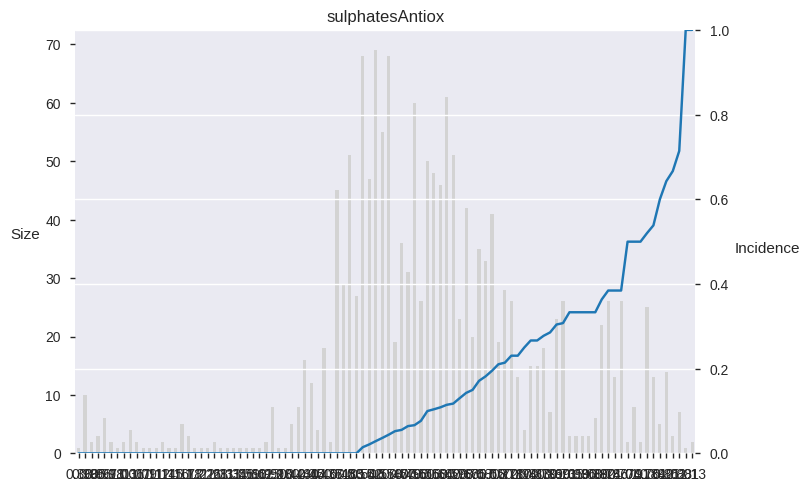

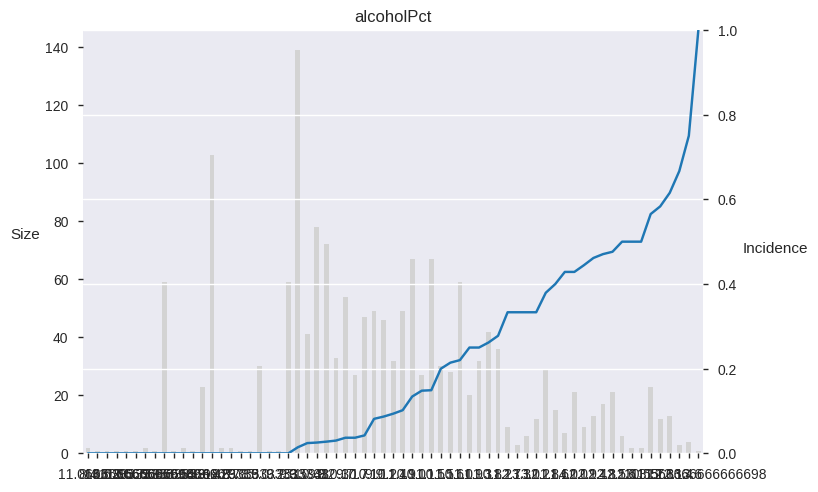

In [17]:
for col in ['fixedAcidity', 'volatileAcidity', 'citricAcid', 'residualSugar',
       'chlorideSalt', 'freeSulfurDioxide', 'totalSulfurDioxide', 'density',
       'pH', 'sulphatesAntiox', 'alcoholPct']:
    pig_table = create_pig_table(df, col, "qualityDiscrete").sort_values(["Incidence"]).reset_index(drop=True)
    plot_pig(pig_table, col)

## data cleaning

In [18]:
# count duplicate rows
np.sum(df.duplicated())

240

In [19]:
# remove the 240 duplicate rows
df = df.drop_duplicates()

## Feature engineering

In [20]:
# investigate zeros
# investigate binning based on the pig plot values

## Visualise features vs target

* X-axis = any feature category
* y-axis = target

In [21]:
targetContinuous = ["qualityScore"]
targetDiscrete = ["qualityDiscrete"]
features = ['fixedAcidity', 'volatileAcidity', 'citricAcid', 'residualSugar',
       'chlorideSalt', 'freeSulfurDioxide', 'totalSulfurDioxide', 'density',
       'pH', 'sulphatesAntiox', 'alcoholPct']

<Figure size 2000x1800 with 0 Axes>

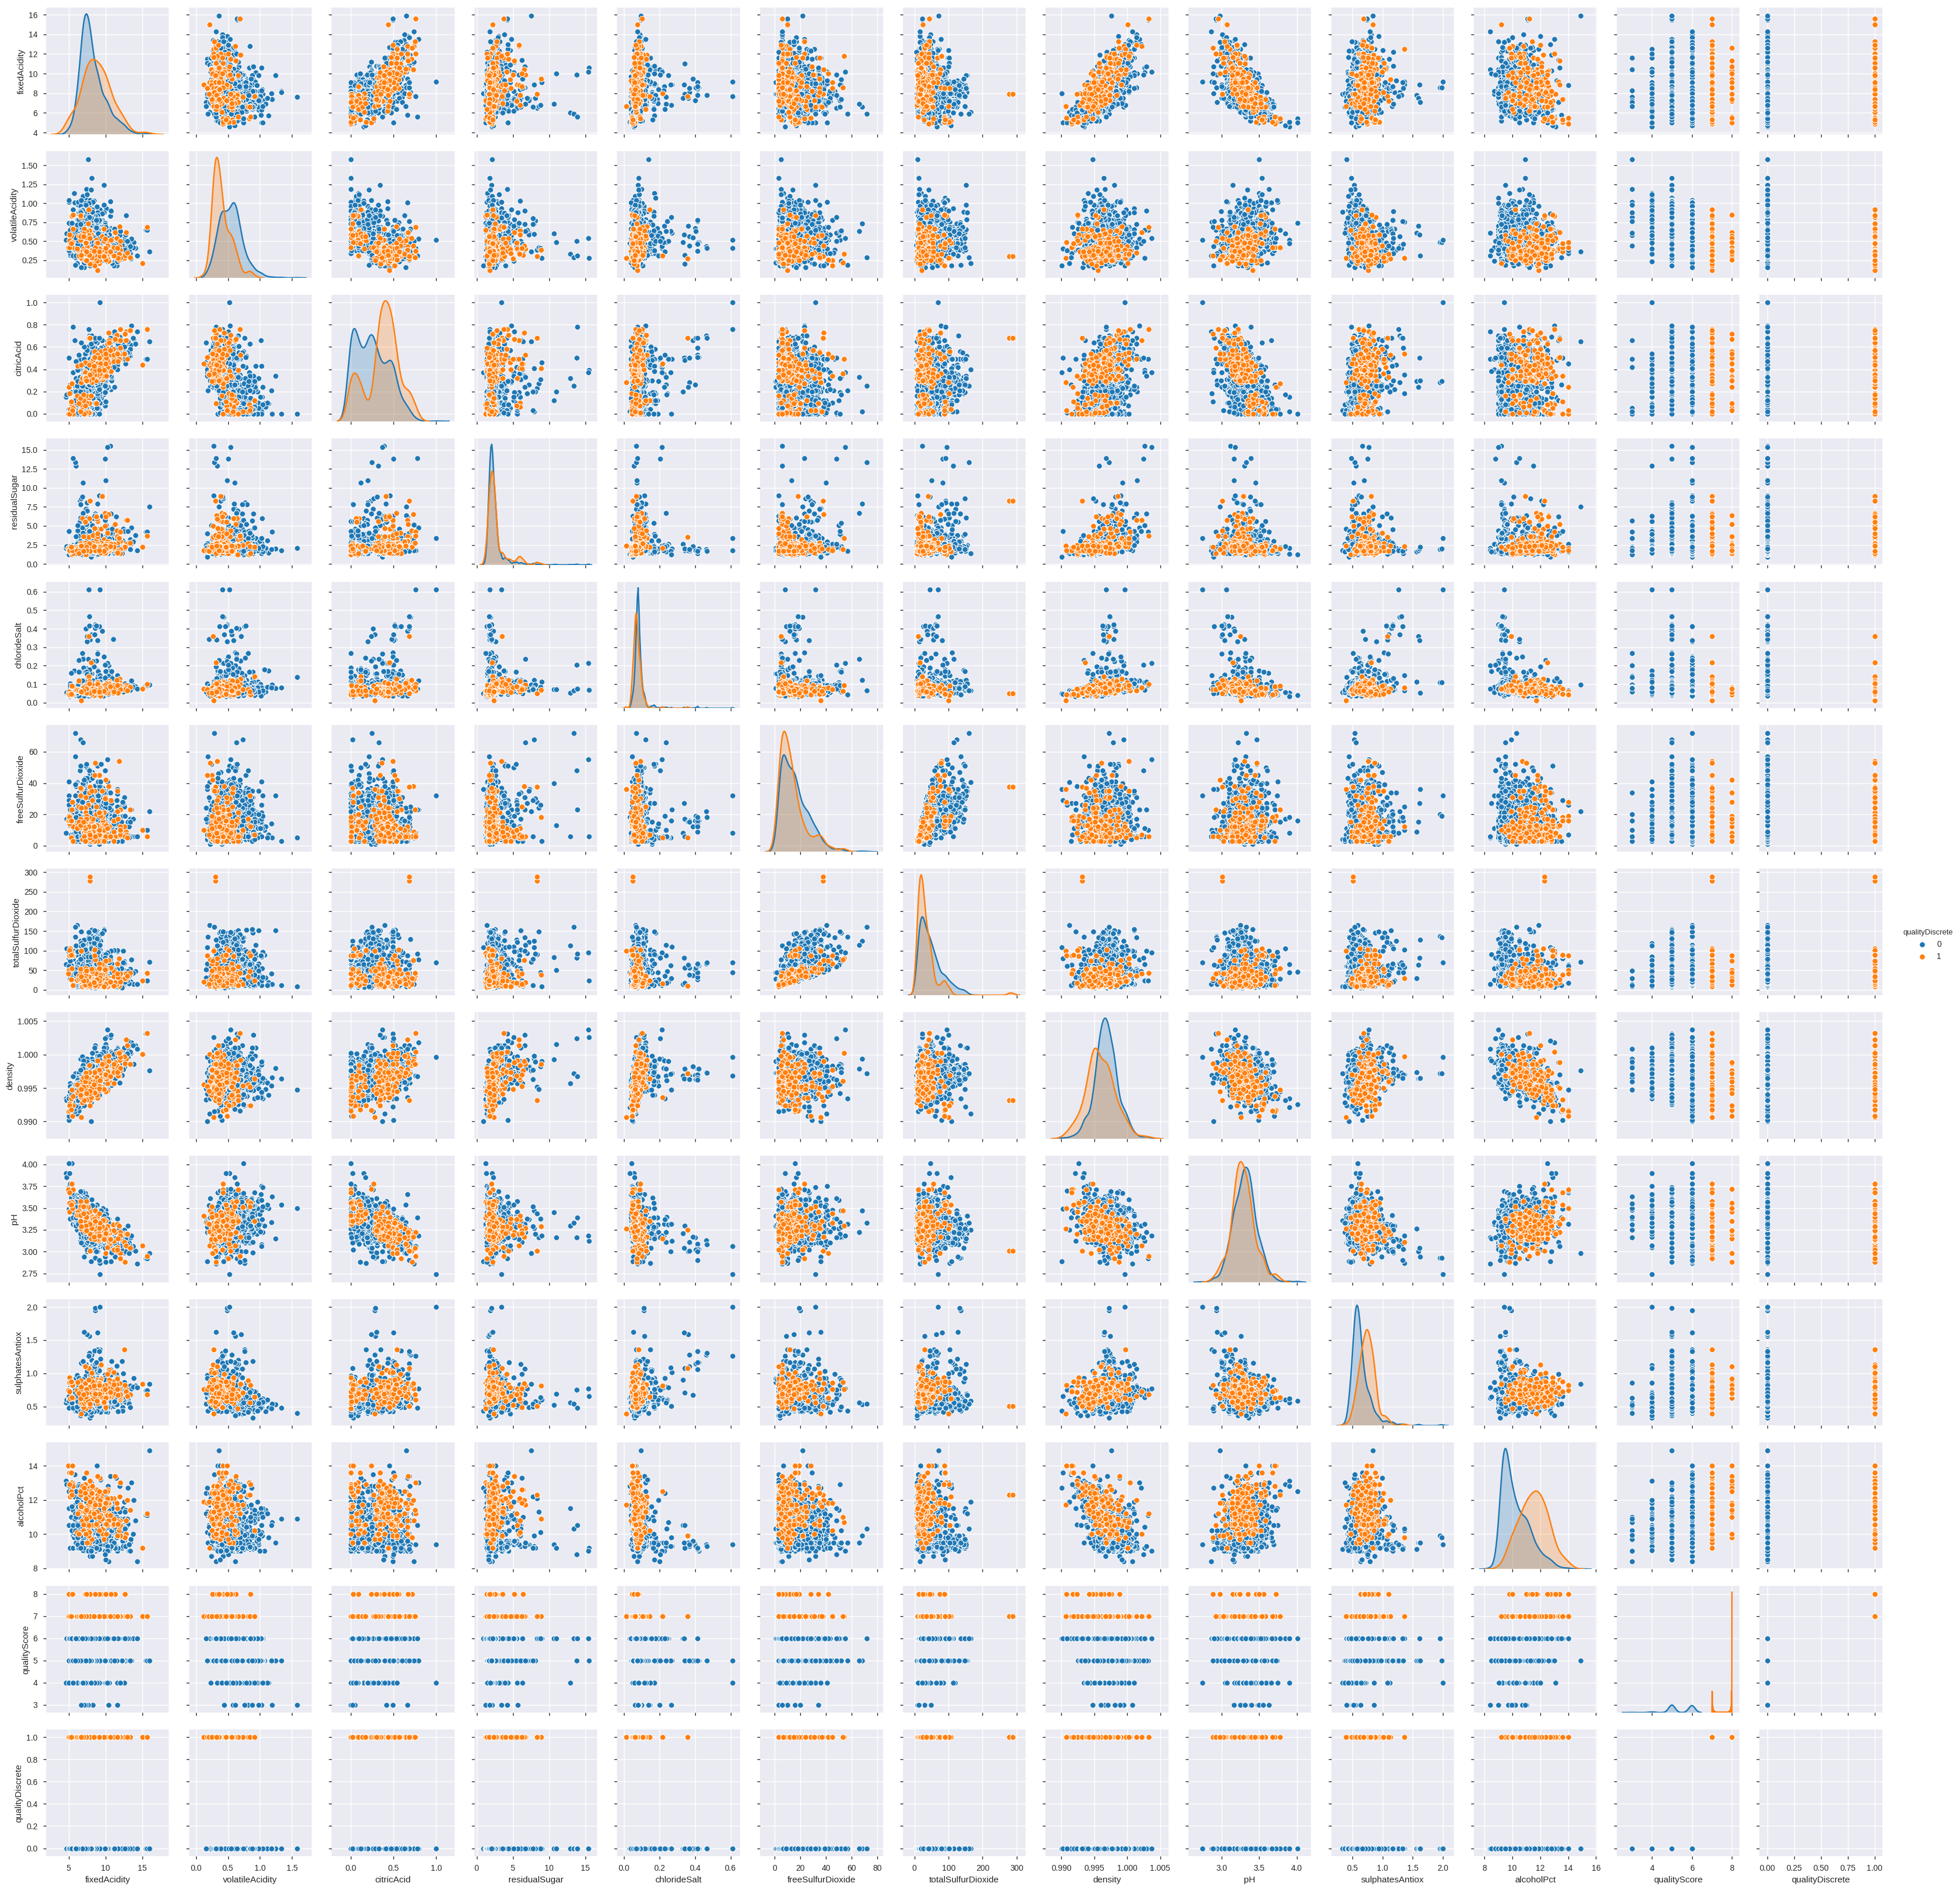

In [22]:
plt.figure(figsize=(20,18))
sns.pairplot(data=df, hue="qualityDiscrete")
plt.savefig("../data/plot/pairplot_binary_hue.png")

**here you see the trends for each feature, if we go higher in the quality**
* density
* cloride

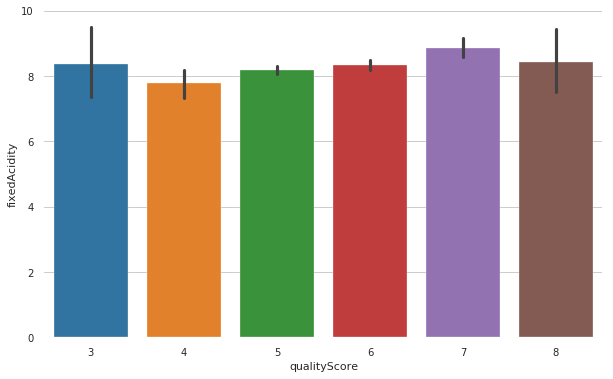

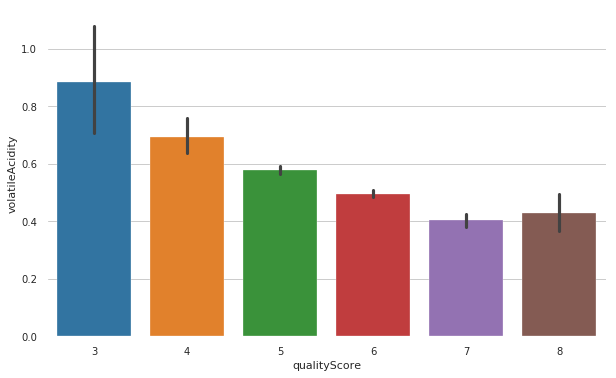

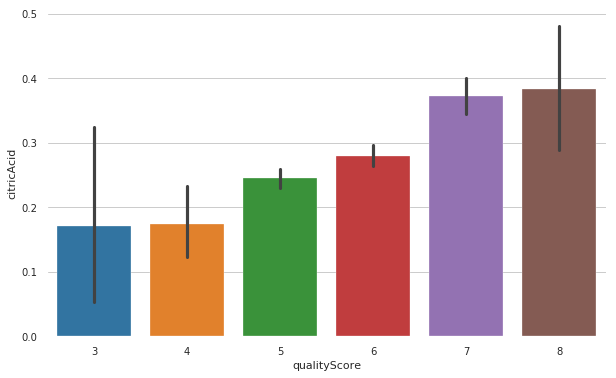

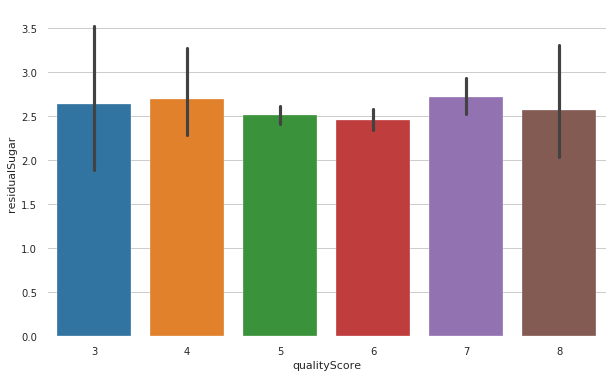

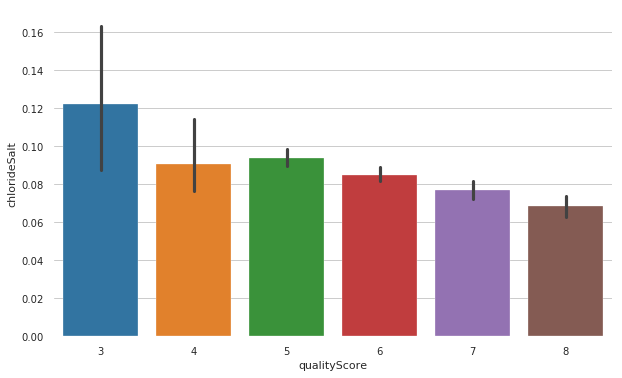

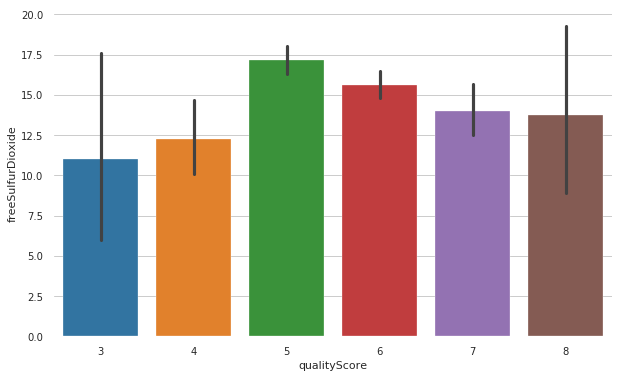

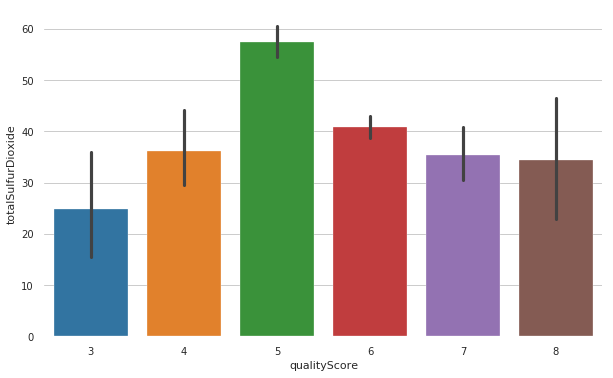

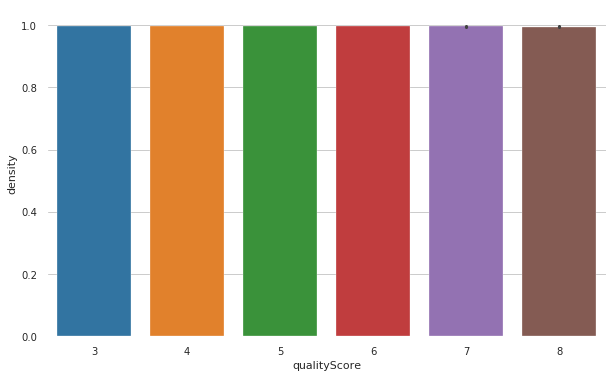

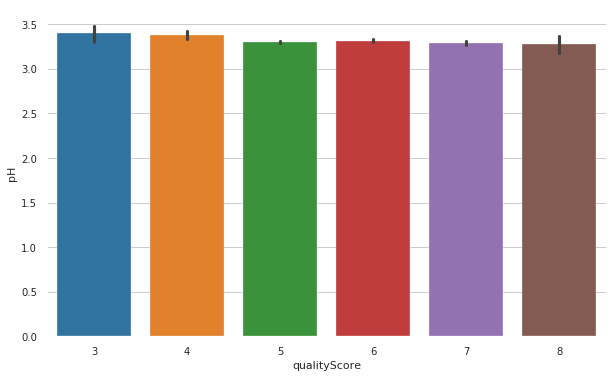

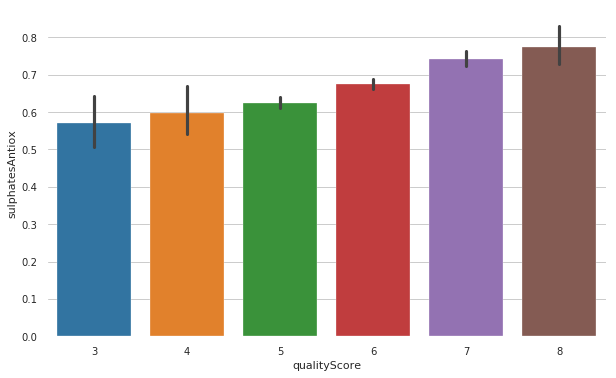

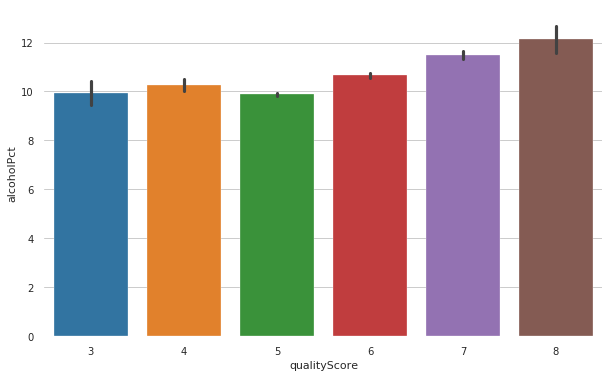

In [143]:
#Here we see that fixed acidity does not give any specification to classify the quality.
def check_quality(df, col):
    fig = plt.figure(figsize = (10,6))
    sns.barplot(x='qualityScore', y=col, data=df)

for col in ['fixedAcidity', 'volatileAcidity', 'citricAcid', 'residualSugar',
       'chlorideSalt', 'freeSulfurDioxide', 'totalSulfurDioxide', 'density',
       'pH', 'sulphatesAntiox', 'alcoholPct']:
    check_quality(df, col)

## Transform Categorical data

In [23]:
# not needed, all features are continuous (pd.get_dummies...)
# binning could be usefull for feature engineering

## create the target dataset

In [22]:
# only target 'qualityScore'
y = df['qualityScore']

## create the features dataset

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1359 entries, 0 to 1598
Data columns (total 13 columns):
fixedAcidity          1359 non-null float64
volatileAcidity       1359 non-null float64
citricAcid            1359 non-null float64
residualSugar         1359 non-null float64
chlorideSalt          1359 non-null float64
freeSulfurDioxide     1359 non-null float64
totalSulfurDioxide    1359 non-null float64
density               1359 non-null float64
pH                    1359 non-null float64
sulphatesAntiox       1359 non-null float64
alcoholPct            1359 non-null float64
qualityScore          1359 non-null int64
qualityDiscrete       1359 non-null int64
dtypes: float64(11), int64(2)
memory usage: 148.6 KB


In [24]:
X = df.select_dtypes(include='float64')#.drop(['...'], axis=1)

## Feature selection

plot cumulative sum variance ratio to show how many variables explain 90% variance effect

### scale the features first

In [32]:
# select the features and target for scaling
# after the scaling we train_test_split using this list of features
X_features = df.iloc[:, 0:len(df.columns) - 2] # this represents the input Features
y_target = df.loc[:, 'qualityScore']

In [58]:
X.columns

Index(['fixedAcidity', 'volatileAcidity', 'citricAcid', 'residualSugar',
       'chlorideSalt', 'freeSulfurDioxide', 'totalSulfurDioxide', 'density',
       'pH', 'sulphatesAntiox', 'alcoholPct'],
      dtype='object')

In [59]:
X_features.columns

Index(['fixedAcidity', 'volatileAcidity', 'citricAcid', 'residualSugar',
       'chlorideSalt', 'freeSulfurDioxide', 'totalSulfurDioxide', 'density',
       'pH', 'sulphatesAntiox', 'alcoholPct'],
      dtype='object')

In [60]:
# Scaling features (only feature NOT observation)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [89]:
# make it back to a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

**Plot the graph to find the principal components**

In [90]:
pca = PCA()

In [91]:
pca_var_ratio = pca.fit(X_scaled).explained_variance_ratio_

(-0.1, 1.1)

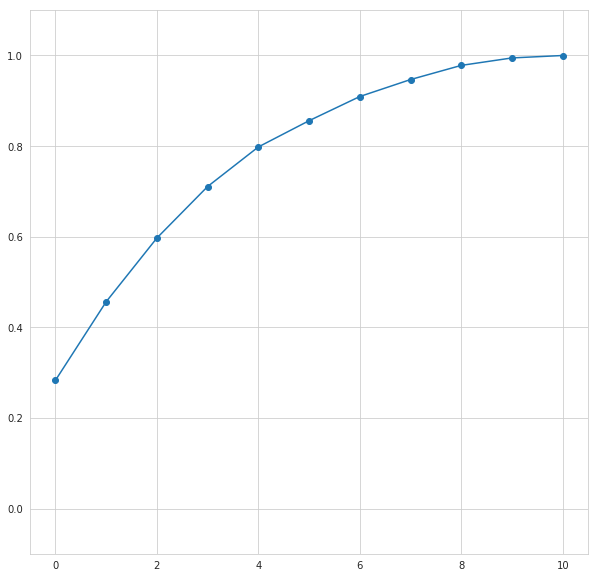

In [92]:
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(pca_var_ratio), marker='o')
plt.ylim([-0.1, 1.1])

In [64]:
# 7 principal components attribute for 90% of variation in the data. 
# We shall pick the first 7 components for our prediction.
# cutoff at 90% means we may use 7/11 variables

## automated feature selection using PCA up to 90%

In [93]:
pca = PCA(n_components=0.9, svd_solver='full')

In [94]:
X_pca = pca.fit_transform(X_scaled)

In [95]:
print("Keep {}/{} features".format(X_pca.shape[1], X_scaled.shape[1]))

Keep 7/11 features


## Split the data for testing results of model

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, stratify=y, random_state=0)

## check the feature correlations  
check if we the independent features are "independent"(good) or "correlated"(bad)

In [69]:
np.abs(X_train.corr()).style.background_gradient()

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

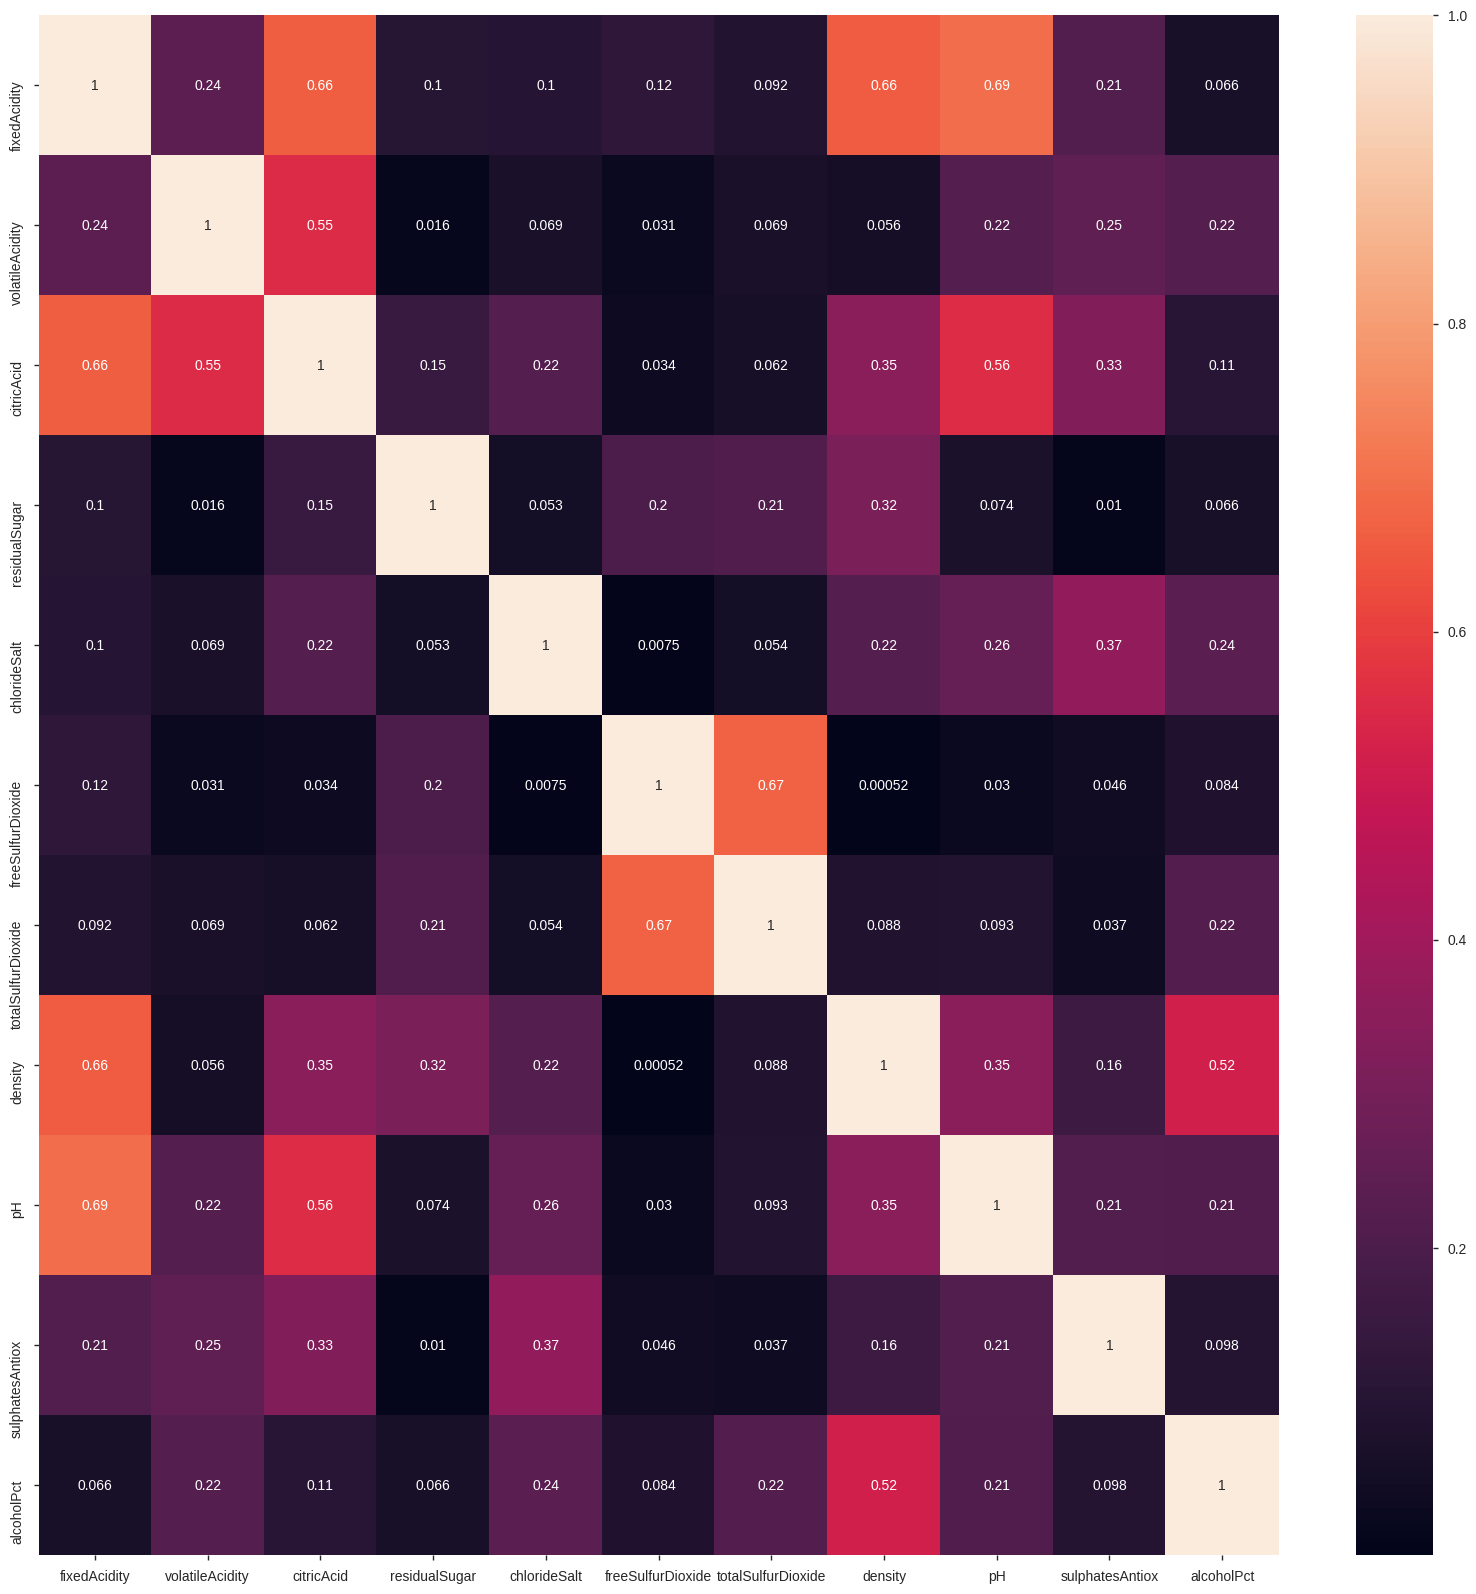

In [29]:
plt.figure(figsize=(20,20))
sns.heatmap(np.abs(X_train.corr()), annot=True)
plt.savefig("../data/plot/feature_correlations.png")

## check the feature correlations with the target  
Be careful this is not a safe method for feature selection, permutation strategies are more robust

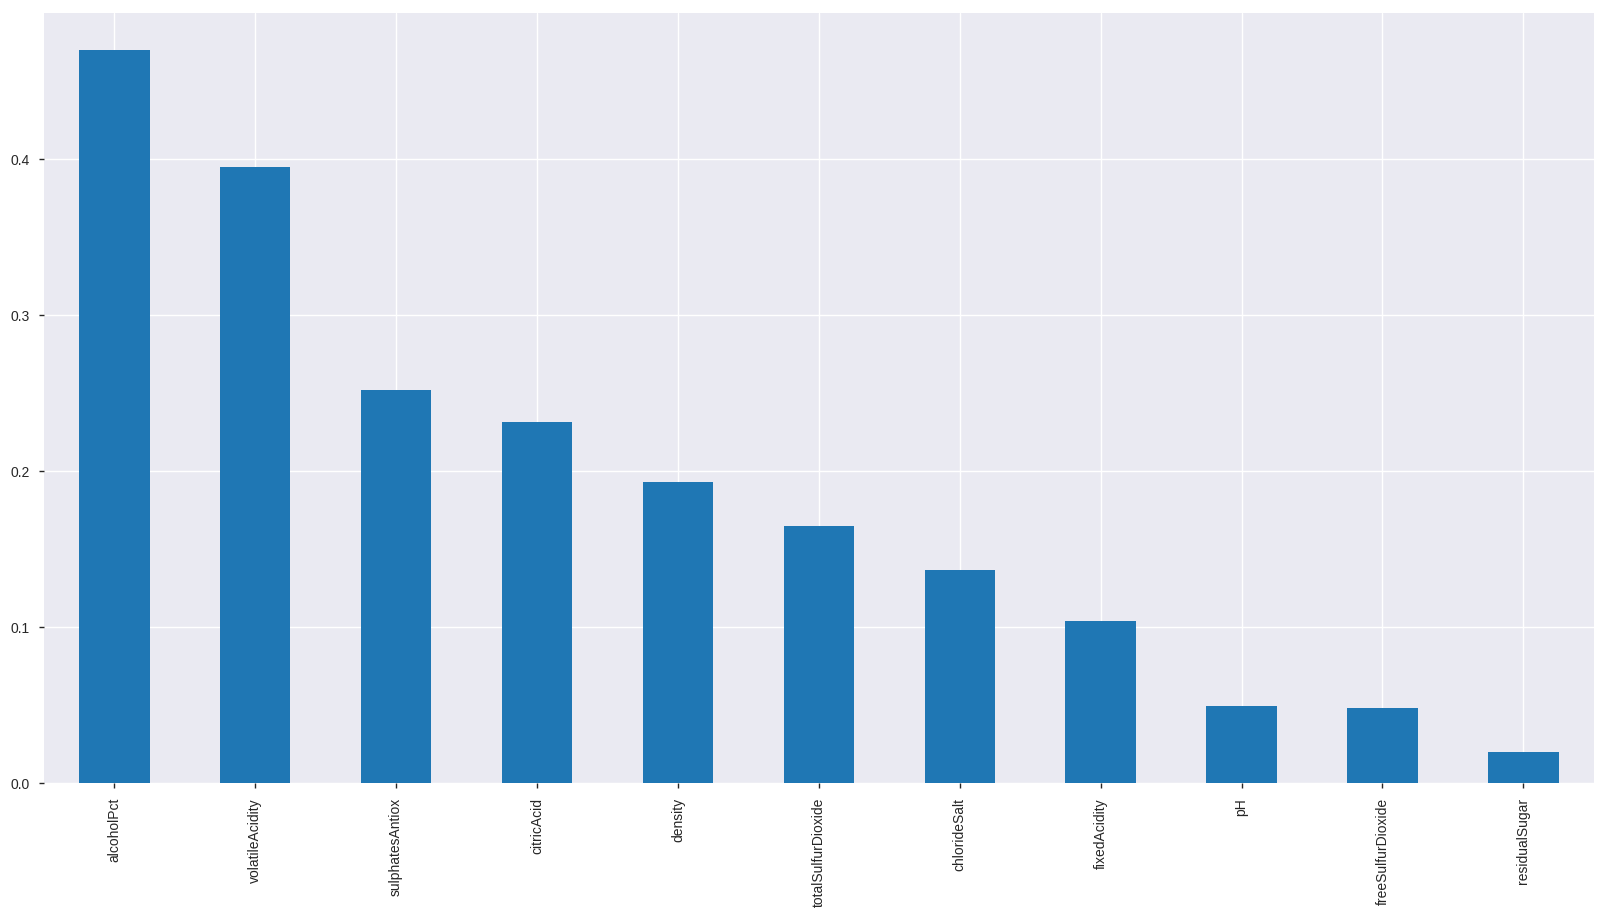

In [30]:
plt.figure(figsize=(20,10))
np.abs(X_train.corrwith(y_train)).sort_values(ascending=False).plot(kind='bar')
plt.savefig("../data/plot/correlations_against_target.png")

## checking variance (width) of each feature  
this can help check in some way for skewness as well because models expect normal distribution  
if np.var() > 1, then we can choose to flatten:
* np.log()
* np.sqrt()

In [31]:
np.var(X_train).sort_values(ascending=False)

totalSulfurDioxide    1113.621969
freeSulfurDioxide      109.767975
fixedAcidity             2.991763
residualSugar            1.690874
alcoholPct               1.181840
citricAcid               0.037933
volatileAcidity          0.032494
sulphatesAntiox          0.029034
pH                       0.024087
chlorideSalt             0.002309
density                  0.000003
dtype: float64

## choose a model

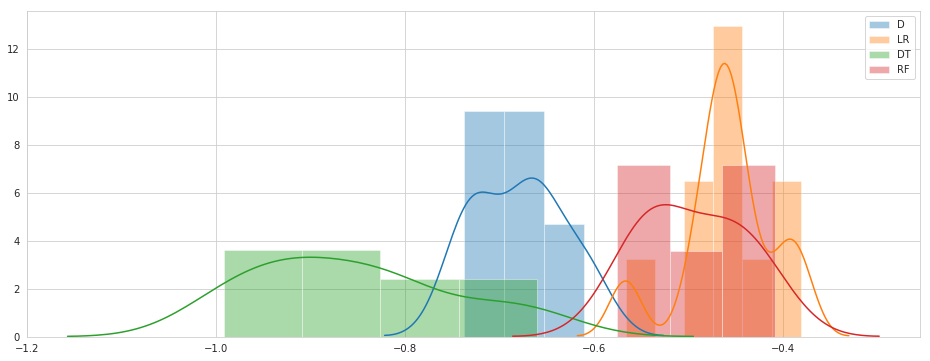

In [71]:
# compare these models:
models = []
models.append(('D', DummyRegressor()))
models.append(('LR', LinearRegression()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))

results = []

# choose the number of CV splits: (recommended: K=10)
n_splits = 10

#cv = KFold(n_splits=n_splits, shuffle=False)          #<== (Regression or ...)
#cv = ShuffleSplit(n_splits=n_splits, shuffle=False)   #<== (Classification only)
cv = StratifiedKFold(n_splits=n_splits, shuffle=False) #<== (Classification or Regression) +Stratify better !

# choose your scoring metric based on Regression group: ...
# https://scikit-learn.org/stable/modules/model_evaluation.html
plt.figure(figsize=(16,6))
for name, model in models:
    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    results.append((name, score))
    sns.distplot(score, label=name)
    plt.legend()
plt.savefig("../data/plot/choose_a_model.png")

results = pd.DataFrame(dict(results))

## Hyperparameter tuning LinearRegression

In [72]:
estimator = LinearRegression()

In [73]:
params={'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

In [74]:
# choose number of splits: (recommended: 10)
# it was chosen before : n_splits=10 folds
cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

In [75]:
grid = GridSearchCV(estimator, param_grid=params, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=3)

In [76]:
%%time
# calculate the best parameters
grid.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] normalize=True, copy_X=True, fit_intercept=True .................
[CV]  normalize=True, copy_X=True, fit_intercept=True, score=-0.4170402000865826, total=   0.0s
[CV] normalize=True, copy_X=True, fit_intercept=True .................
[CV]  normalize=True, copy_X=True, fit_intercept=True, score=-0.4871324292496891, total=   0.0s
[CV] normalize=True, copy_X=True, fit_intercept=True .................
[CV]  normalize=True, copy_X=True, fit_intercept=True, score=-0.4346570580849658, total=   0.0s
[CV] normalize=True, copy_X=True, fit_intercept=True .................
[CV]  normalize=True, copy_X=True, fit_intercept=True, score=-0.47471712736950966, total=   0.0s
[CV] normalize=True, copy_X=True, fit_intercept=True .................
[CV]  normalize=True, copy_X=True, fit_intercept=True, score=-0.5053400144301671, total=   0.0s
[CV] normalize=True, copy_X=True, fit_intercept=True .................
[CV]  normalize=True, copy_X=Tru

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] normalize=False, copy_X=False, fit_intercept=False ..............
[CV]  normalize=False, copy_X=False, fit_intercept=False, score=-32.103894316390274, total=   0.0s
[CV] normalize=False, copy_X=False, fit_intercept=False ..............
[CV]  normalize=False, copy_X=False, fit_intercept=False, score=-32.3452269045905, total=   0.0s
[CV] normalize=False, copy_X=False, fit_intercept=False ..............
[CV]  normalize=False, copy_X=False, fit_intercept=False, score=-32.605197726261046, total=   0.0s
[CV] normalize=False, copy_X=False, fit_intercept=False ..............
[CV]  normalize=False, copy_X=False, fit_intercept=False, score=-32.922728924034146, total=   0.0s
CPU times: user 208 ms, sys: 8 ms, total: 216 ms
Wall time: 222 ms


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'normalize': [True, False], 'copy_X': [True, False], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=3)

## hyperparameter Results

In [77]:
grid.__dict__

{'best_estimator_': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True),
 'best_index_': 0,
 'best_params_': {'copy_X': True, 'fit_intercept': True, 'normalize': True},
 'best_score_': -0.4572321392682847,
 'cv': StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
 'cv_results_': {'mean_fit_time': array([0.00139401, 0.00110016, 0.00102718, 0.00096848, 0.00124087,
         0.00110986, 0.00099957, 0.00099168]),
  'mean_score_time': array([0.00039918, 0.00040004, 0.00039501, 0.00040047, 0.00039632,
         0.0003984 , 0.00040092, 0.00057838]),
  'mean_test_score': array([ -0.45723214,  -0.45723214, -32.42588949, -32.42588949,
          -0.45723214,  -0.45723214, -32.42588949, -32.42588949]),
  'mean_train_score': array([ -0.45125309,  -0.45125309, -32.06656442, -32.06656442,
          -0.66830381,  -0.4512641 , -32.06656442, -32.06656442]),
  'param_copy_X': masked_array(data=[True, True, True, True, False, False, False, False],
               mask=[

In [78]:
lm = grid.best_estimator_
# similar to:
# lm = LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

**Print out the coefficients of the model**

In [79]:
# The coefficients
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [ 0.04829567 -0.22779989  0.26313546 -0.03298597  0.06528898 -0.04204626
 -0.08851971]


## conclusion
**interpret these coefficients**

In [80]:
coeffecients = pd.DataFrame(lm.coef_, X_train.columns, columns=['Coeffecient'])
coeffecients

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

Interpreting the coefficients:

- Holding all other features fixed, a 1 unit increase in **alcoholPct** is associated with an **increase of 0.3 quality points**.
- Holding all other features fixed, a 1 unit increase in **volatileAcidity** is associated with a **decrease of 1.1 quality points**.
- Holding all other features fixed, a 1 unit increase in **sulphatesAntiox** is associated with an **increase of 0.9 quality points**.
- Holding all other features fixed, a 1 unit increase in **chlorideSalt** is associated with a **decrease of 2.1 quality points**.
- etc...

**Print out the intercept of the model**

In [81]:
# The coefficients
print('Intercept: \n', lm.intercept_)

Intercept: 
 5.624617924627337


In [82]:
lm.__dict__

{'_residues': 490.83490218992677,
 'coef_': array([ 0.04829567, -0.22779989,  0.26313546, -0.03298597,  0.06528898,
        -0.04204626, -0.08851971]),
 'copy_X': True,
 'fit_intercept': True,
 'intercept_': 5.624617924627337,
 'n_jobs': None,
 'normalize': True,
 'rank_': 7,
 'singular_': array([1.02474298, 1.01911318, 1.00727238, 0.99569856, 0.99282901,
        0.98768029, 0.97163525])}

## final predictions

In [83]:
# create prediction values
# notice: the X_test has had the same feature cleaning, engineering, transformations !
y_predict = grid.predict(X_test)

**Create a scatterplot of the real test values versus the predicted values.**

Text(0, 0.5, 'y predict')

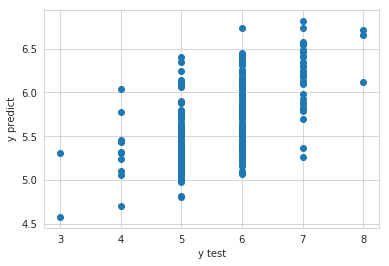

In [84]:
plt.scatter(y_test, y_predict)
plt.xlabel('y test')
plt.ylabel('y predict')

## Model Evaluation  
**evaluate our model performance by calculating the**  
* Mean Absolute Error
* Mean Squared Error
* Root Mean Squared Error
* R² Score

In [115]:
# calculate the Mean Squared Error,
# remember you need to use predict_proba
print('MAE:', mean_absolute_error(y_test, y_predict))
print('MSE:', mean_squared_error(y_test, y_predict))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_predict)))
print('R²:', r2_score(y_test, y_predict))

MAE: 0.47885083101252673
MSE: 0.3892563954454796
RMSE: 0.6239041556565236
R²: 0.4197427986412048


## Residuals  
make sure everything was okay with our data.  
histogram of the residuals and make sure it looks normally distributed.

**using seaborn**

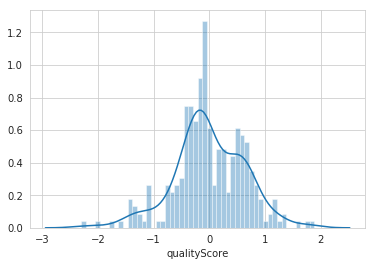

In [86]:
sns.distplot((y_test - y_predict), bins=50)

## detect BIAS and Feature Importance (Permutation method)

In [87]:
# performance intensive
perm = PermutationImportance(grid.best_estimator_)

NameError: name 'PermutationImportance' is not defined

In [90]:
%time
perm.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.68 µs


PermutationImportance(cv='prefit',
           estimator=LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=True),
           n_iter=5, random_state=None, refit=True, scoring=None)

In [91]:
# to see the importance values : feature_importances_
perm.__dict__

{'refit': True,
 'estimator': LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
          normalize=True),
 'scoring': None,
 'n_iter': 5,
 'random_state': None,
 'cv': 'prefit',
 'rng_': <mtrand.RandomState at 0x7fe6240973a8>,
 'scorer_': <function sklearn.metrics.scorer._passthrough_scorer(estimator, *args, **kwargs)>,
 'scores_': array([0.34811193, 0.34811193, 0.34811193, 0.34811193, 0.34811193]),
 'results_': [array([ 5.30447491e-03,  1.19447400e-01, -4.26226728e-04,  2.50169726e-04,
          3.39858365e-02,  3.46704334e-03,  2.91098640e-02, -8.27283992e-06,
          1.81936898e-02,  5.44692020e-02,  2.90124761e-01]),
  array([ 5.09720874e-03,  1.21416405e-01, -1.07610723e-04,  3.29991863e-04,
          2.30377217e-02,  2.36368594e-03,  2.46789743e-02,  4.15266711e-04,
          2.34783958e-02,  6.39329255e-02,  2.99114583e-01]),
  array([ 2.61312308e-03,  1.31265791e-01,  1.00790504e-04,  7.27594386e-04,
          2.83113330e-02,  1.39705661e-03,  2.30448443e-02, -

In [92]:
# green/red : positive/negative importance
# zero's and negatives features can be removed
# BIAS : optional value to watch out for
# this is better than doing a correlation with target

eli5.show_weights(perm, feature_names=X_train.columns.values, top=None)

#if it fails use below:
#eli5.show_weights(perm, feature_names=X_train.columns.values, top=None)